# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
import datetime
import os

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow.keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)
from tensorflow.compat.v1.keras.backend import set_session

config = tf.compat.v1.ConfigProto()

config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU

config.log_device_placement = True  # to log device placement (on which device the operation ran)

sess = tf.compat.v1.Session(config=config)

set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1



We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow.keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
import matplotlib.pyplot as plt
import cv2

In [5]:
image=cv2.imread('Project_data/Project_data/val/WIN_20180907_15_50_39_Pro_Right Swipe_new/WIN_20180907_15_50_39_Pro_00035.png')

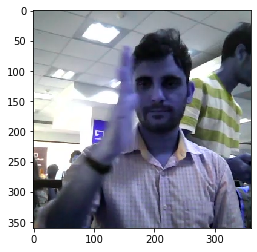

In [6]:
plt.imshow(np.real(image))

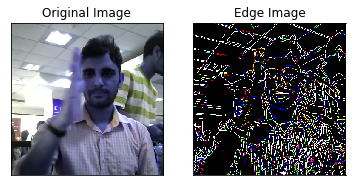

In [15]:
res=image.copy()
res[:,:,0]=cv2.Canny(image[:,:,0],40,80)
res[:,:,1]=cv2.Canny(image[:,:,1],40,80)
res[:,:,2]=cv2.Canny(image[:,:,2],40,80)

plt.subplot(121),plt.imshow(image,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(res,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

In [17]:
image.shape

(360, 360, 3)

In [18]:
res.shape

(360, 360, 3)

In [24]:
train_doc = np.random.permutation(open('Project_data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/Project_data/val.csv').readlines())
batch_size = 64 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [54]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [i for i in range(30) if i%2==1] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),90,90,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    res=cv2.resize(image,(90,90))
                    
                    batch_data[folder,idx,:,:,0] = res[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = res[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = res[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if len(folder_list)%batch_size!=0:
            remaining=len(folder_list)%batch_size
            si=len(folder_list)-remaining
            batch_data = np.zeros((remaining,len(img_idx),90,90,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((remaining,5)) # batch_labels is the one hot representation of the output
            for folder in range(remaining):
                imgs = os.listdir(source_path+'/'+ t[si].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[si].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    res=cv2.resize(image,(90,90))
                    
                    batch_data[folder,idx,:,:,0] = res[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = res[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = res[:,:,2]/255 #normalise and feed in the image
                        
                batch_labels[folder, int(t[si].strip().split(';')[2])] = 1
                si+=1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
                


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [12]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/Project_data/train'
val_path = 'Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


In [35]:
#function to make the lost accuracy plot
def pla(history):
    
    # summarize history for loss
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.subplot(1,2,2)
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    

***Please note that test in the graph means val. We realized this later on and did not have enough nimblebox credits to run the model again. Thanks a lot for your understanding.***

## Model-1 Conv3D model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [17]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from keras import optimizers


#write your model here
model=Sequential()

#first 3D conv group
model.add(Conv3D(8,(3,3,3),padding='same',input_shape=(15,90,90,3),kernel_initializer=keras.initializers.he_normal()))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(8,(3,3,3),padding='same',input_shape=(15,90,90,3),kernel_initializer=keras.initializers.he_normal()))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

#second 3D conv group
model.add(Conv3D(16,(3,3,3),padding='same',kernel_initializer=keras.initializers.he_normal()))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(16,(3,3,3),padding='same',kernel_initializer=keras.initializers.he_normal()))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

#third 3D conv group
model.add(Conv3D(32,(3,3,3),padding='same',kernel_initializer=keras.initializers.he_normal()))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(32,(3,3,3),padding='same',kernel_initializer=keras.initializers.he_normal()))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(16,activation='relu'))
model.add(BatchNormalization())

# softmax layer
model.add(Dense(5, activation='softmax'))

In [18]:
optimiser = optimizers.SGD(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 15, 90, 90, 8)     656       
_________________________________________________________________
activation_7 (Activation)    (None, 15, 90, 90, 8)     0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 15, 90, 90, 8)     32        
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 15, 90, 90, 8)     1736      
_________________________________________________________________
activation_8 (Activation)    (None, 15, 90, 90, 8)     0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 7, 45, 45, 8)      0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 7, 45, 45, 8)     

In [19]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [20]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(
    monitor='val_loss', factor=0.4, patience=5, verbose=0, mode='auto',
    min_delta=0.001, cooldown=0) # write the REducelronplateau code here
ES = EarlyStopping(monitor='val_loss',patience=7)
callbacks_list = [checkpoint, LR, ES]

In [21]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [22]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
Source path = Source path =  Project_data/Project_data/train ; batch size = 64
 Project_data/Project_data/val ; batch size = 64
11/11 [==============================] - 41s 4s/step - loss: 1.7588 - categorical_accuracy: 0.3017 - val_loss: 1.5663 - val_categorical_accuracy: 0.1800

Epoch 00001: saving model to model_init_2020-05-2718_26_44.353714/model-00001-1.76344-0.30166-1.56625-0.18000.h5
Epoch 2/50
11/11 [==============================] - 30s 3s/step - loss: 1.0957 - categorical_accuracy: 0.5686 - val_loss: 1.6454 - val_categorical_accuracy: 0.1500

Epoch 00002: saving model to model_init_2020-05-2718_26_44.353714/model-00002-1.09465-0.56863-1.64535-0.15000.h5
Epoch 3/50
11/11 [==============================] - 31s 3s/step - loss: 0.7593 - categorical_accuracy: 0.7481 - val_loss: 1.5476 - val_categorical_accuracy: 0.3000

Epoch 00003: saving model to model_init_2020-05-2718_26_44.353714/model-00003-0.76220-0.74811-1.54762-0.30000.h5
Epoch 4/50
11/11 [====================

In [24]:
history=model.history

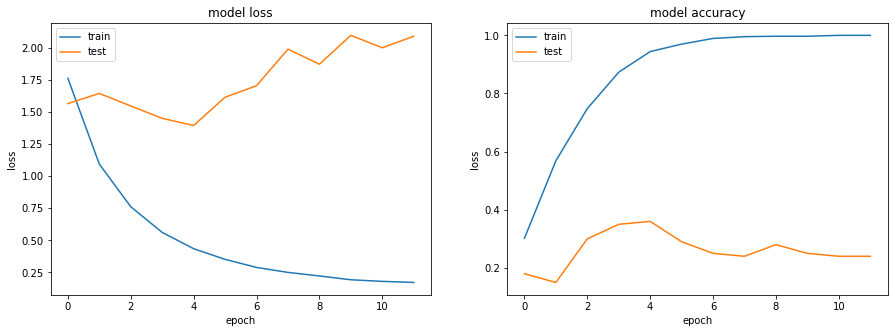

In [25]:
pla(history)

Hence, we observe that our model is learning but it is overfitting.

# Model 2-Conv 3D Model with Dropouts

In [0]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers


#write your model here
model=Sequential()

#first 3D conv group
model.add(Conv3D(8,(3,3,3),padding='same',input_shape=(15,90,90,3),kernel_initializer=keras.initializers.he_normal()))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(8,(3,3,3),padding='same',input_shape=(15,90,90,3),kernel_initializer=keras.initializers.he_normal()))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

#second 3D conv group
model.add(Conv3D(16,(3,3,3),padding='same',kernel_initializer=keras.initializers.he_normal()))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(16,(3,3,3),padding='same',kernel_initializer=keras.initializers.he_normal()))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

#third 3D conv group
model.add(Conv3D(32,(3,3,3),padding='same',kernel_initializer=keras.initializers.he_normal()))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(32,(3,3,3),padding='same',kernel_initializer=keras.initializers.he_normal()))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(16,activation='relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

# softmax layer
model.add(Dense(5, activation='softmax'))

In [0]:
optimiser = optimizers.SGD(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_37 (Conv3D)           (None, 15, 90, 90, 8)     656       
_________________________________________________________________
activation_37 (Activation)   (None, 15, 90, 90, 8)     0         
_________________________________________________________________
batch_normalization_61 (Batc (None, 15, 90, 90, 8)     32        
_________________________________________________________________
conv3d_38 (Conv3D)           (None, 15, 90, 90, 8)     1736      
_________________________________________________________________
activation_38 (Activation)   (None, 15, 90, 90, 8)     0         
_________________________________________________________________
max_pooling3d_19 (MaxPooling (None, 7, 45, 45, 8)      0         
_________________________________________________________________
batch_normalization_62 (Batc (None, 7, 45, 45, 8)     

In [0]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [0]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/Project_data/train'
val_path = 'Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


In [0]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(
    monitor='val_loss', factor=0.4, patience=3, verbose=1, mode='auto',
    min_delta=0.001, cooldown=5,min_lr=0.00001) # write the REducelronplateau code here
ES= EarlyStopping(monitor='val_loss',patience=6)
callbacks_list = [checkpoint, LR]

In [0]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [0]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
Source path =  Project_data/Project_data/train ; batch size = 64
Source path =  Project_data/Project_data/val ; batch size = 64
11/11 [==============================] - 35s 3s/step - loss: 1.8257 - categorical_accuracy: 0.2549 - val_loss: 1.8347 - val_categorical_accuracy: 0.1800

Epoch 00001: saving model to model_init_2020-05-2613_32_27.983106/model-00001-1.82640-0.25490-1.83468-0.18000.h5
Epoch 2/50
11/11 [==============================] - 33s 3s/step - loss: 1.5698 - categorical_accuracy: 0.3560 - val_loss: 1.6114 - val_categorical_accuracy: 0.3300

Epoch 00002: saving model to model_init_2020-05-2613_32_27.983106/model-00002-1.57965-0.35596-1.61143-0.33000.h5
Epoch 3/50
11/11 [==============================] - 33s 3s/step - loss: 1.3477 - categorical_accuracy: 0.4389 - val_loss: 1.8532 - val_categorical_accuracy: 0.2300

Epoch 00003: saving model to model_init_2020-05-2613_32_27.983106/model-00003-1.35487-0.43891-1.85315-0.23000.h5
Epoch 4/50
11/11 [====================

In [0]:
history=model.history

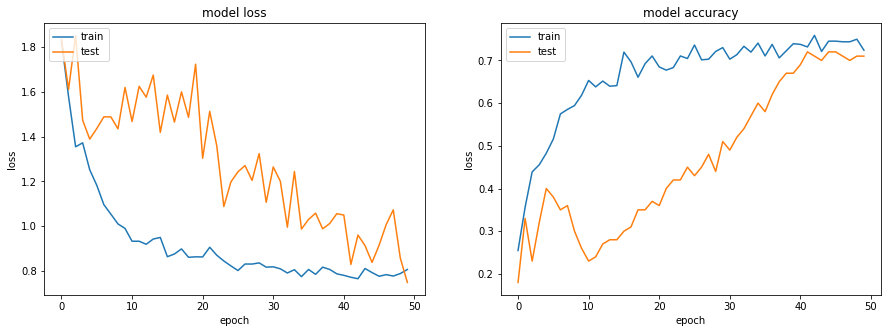

In [0]:
pla(history)

We observe that the model is learning with lesser overfitting but the learning is happening really slowly. Therefore, we try to increase the learning rate.

In [0]:
optimiser = optimizers.SGD(lr=0.1) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_37 (Conv3D)           (None, 15, 90, 90, 8)     656       
_________________________________________________________________
activation_37 (Activation)   (None, 15, 90, 90, 8)     0         
_________________________________________________________________
batch_normalization_61 (Batc (None, 15, 90, 90, 8)     32        
_________________________________________________________________
conv3d_38 (Conv3D)           (None, 15, 90, 90, 8)     1736      
_________________________________________________________________
activation_38 (Activation)   (None, 15, 90, 90, 8)     0         
_________________________________________________________________
max_pooling3d_19 (MaxPooling (None, 7, 45, 45, 8)      0         
_________________________________________________________________
batch_normalization_62 (Batc (None, 7, 45, 45, 8)     

In [0]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [0]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/Project_data/train'
val_path = 'Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


In [0]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(
    monitor='val_loss', factor=0.4, patience=3, verbose=1, mode='auto',
    min_delta=0.001, cooldown=5,min_lr=0.00001) # write the REducelronplateau code here
ES= EarlyStopping(monitor='val_loss',patience=6)
callbacks_list = [checkpoint, LR,ES]

In [0]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [0]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
Source path =  Project_data/Project_data/val ; batch size = 64
Source path =  Project_data/Project_data/train ; batch size = 64
11/11 [==============================] - 29s 3s/step - loss: 1.0795 - categorical_accuracy: 0.5807 - val_loss: 3.5650 - val_categorical_accuracy: 0.3600

Epoch 00001: saving model to model_init_2020-05-2613_56_30.895611/model-00001-1.08323-0.58069-3.56505-0.36000.h5
Epoch 2/50
11/11 [==============================] - 23s 2s/step - loss: 0.9475 - categorical_accuracy: 0.6486 - val_loss: 1.4014 - val_categorical_accuracy: 0.4100

Epoch 00002: saving model to model_init_2020-05-2613_56_30.895611/model-00002-0.93632-0.64857-1.40139-0.41000.h5
Epoch 3/50
11/11 [==============================] - 28s 3s/step - loss: 0.9126 - categorical_accuracy: 0.6772 - val_loss: 9.0459 - val_categorical_accuracy: 0.2300

Epoch 00003: saving model to model_init_2020-05-2613_56_30.895611/model-00003-0.89925-0.67722-9.04592-0.23000.h5
Epoch 4/50
11/11 [====================

In [0]:
history=model.history

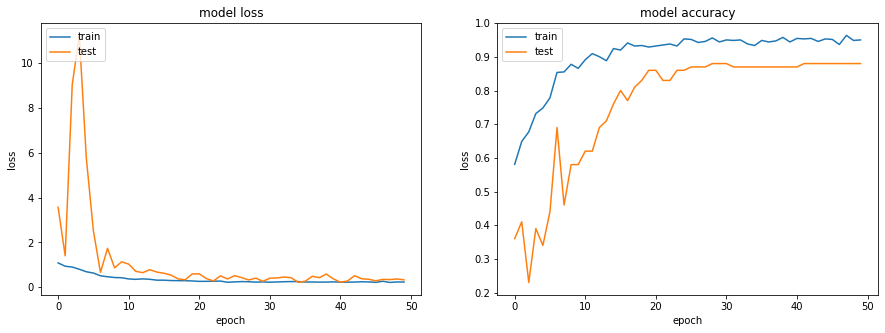

In [0]:
pla(history)

Here, we observe that the model has reach 95% Training Accuracy and 88% validation accuracy. This looks like a great model to go with because of reduced overfitting and higher accuracies.

# Model 3- Conv 2D + RNN Self Made Model

In [27]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling3D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers.recurrent import LSTM
from keras import optimizers
from keras.layers import Dropout

#write your model here
model = Sequential()

# Conv2D Timedistributed model 1 with 8 layers
model.add(TimeDistributed(Conv2D(8, (3, 3) , padding='same', activation='relu'),input_shape=(15,90,90,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

# Conv2D Timedistributed model 2 with 16 layers
model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

# Conv2D Timedistributed model 3 with 32 layers
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

# Conv2D Timedistributed model 4 with 64 layers
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.2))

# Conv2D Timedistributed model 5 with 128 layers
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.2))

#Conv2D Timedistributed model 6 with 256 layers
#model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
#model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

# flatten and put a fully connected layer

model.add(TimeDistributed(Flatten()))

# model.add(LRU(128))
#model.add(Dropout(0.5))

model.add(GRU(128))
model.add(Dropout(0.4))
        
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.25))
        
model.add(Dense(5, activation='softmax'))

In [249]:
optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_113 (TimeDi (None, 15, 90, 90, 8)     224       
_________________________________________________________________
time_distributed_114 (TimeDi (None, 15, 90, 90, 8)     32        
_________________________________________________________________
time_distributed_115 (TimeDi (None, 15, 45, 45, 8)     0         
_________________________________________________________________
time_distributed_116 (TimeDi (None, 15, 45, 45, 16)    1168      
_________________________________________________________________
time_distributed_117 (TimeDi (None, 15, 45, 45, 16)    64        
_________________________________________________________________
time_distributed_118 (TimeDi (None, 15, 22, 22, 16)    0         
_________________________________________________________________
time_distributed_119 (TimeDi (None, 15, 22, 22, 32)  

In [250]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/Project_data/train'
val_path = 'Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size=32

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [0]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [0]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(
    monitor='val_loss', factor=0.4, patience=3, verbose=1, mode='auto',
    min_delta=0.001, cooldown=0,min_lr=0.00001) # write the REducelronplateau code here
ES=EarlyStopping(monitor='val_loss',patience=5)
callbacks_list = [checkpoint, LR]

In [0]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [254]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
Source path =  Project_data/Project_data/val ; batch size = 32
Source path =  Project_data/Project_data/train ; batch size = 32
21/21 [==============================] - 28s 1s/step - loss: 1.5803 - categorical_accuracy: 0.3017 - val_loss: 1.5176 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2020-05-2621_09_59.358545/model-00001-1.58148-0.30166-1.51755-0.21000.h5
Epoch 2/20
21/21 [==============================] - 21s 1s/step - loss: 1.3494 - categorical_accuracy: 0.4284 - val_loss: 1.6283 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to model_init_2020-05-2621_09_59.358545/model-00002-1.35014-0.42836-1.62826-0.21000.h5
Epoch 3/20
21/21 [==============================] - 22s 1s/step - loss: 1.1957 - categorical_accuracy: 0.4947 - val_loss: 2.0075 - val_categorical_accuracy: 0.2100

Epoch 00003: saving model to model_init_2020-05-2621_09_59.358545/model-00003-1.19761-0.49472-2.00749-0.21000.h5
Epoch 4/20
21/21 [====================

In [0]:
history=model.history

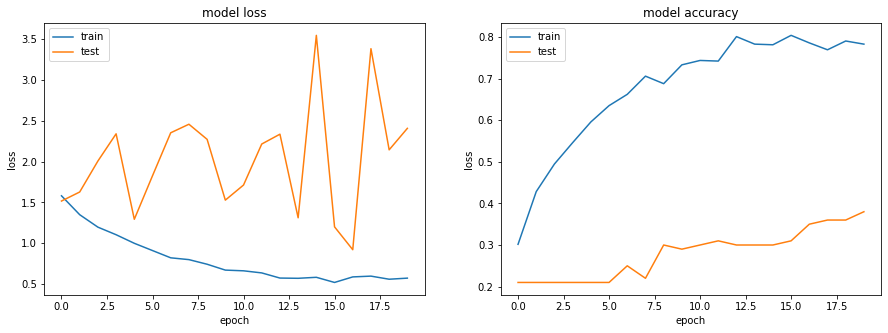

In [256]:
pla(history)

Here, we observe that the model is overfitting. We try Transfer Learning so that less training happens.

# Model-4 Transfer Learning with GRU

We had already checked that this model was learning. We now add Dropout layers accordingly to prevent overfitting in the model. We experimented with different batch sizes and the optimal batch size to be found was 16. The optimal learning rate was found to be 0.001 after many experiments. The learning rate reduced by a factor of 0.4 as a plateau was reached on the val_loss plot.

***Note: All these experiments were done on Google Colab. Hence, there is a change in path.***

In [232]:
from keras.applications import mobilenet
from keras.callbacks import ModelCheckpoint, EarlyStopping


mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=(15,90,90,3)))
 
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(128))
# model.add(Dropout(0.6))
        
model.add(Dense(16,activation='relu'))
model.add(Dense(32,activation='relu'))
# model.add(Dense(64,activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(64,activation='relu'))
model.add(Dropout(0.6))
        
model.add(Dense(5, activation='softmax'))

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [233]:
# Get the model
# model = get_model()
optimiser = optimizers.Adam(lr=0.001, clipnorm=1.) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_93 (TimeDis (None, 15, 2, 2, 1024)    3228864   
_________________________________________________________________
time_distributed_94 (TimeDis (None, 15, 2, 2, 1024)    4096      
_________________________________________________________________
time_distributed_95 (TimeDis (None, 15, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_96 (TimeDis (None, 15, 1024)          0         
_________________________________________________________________
gru_21 (GRU)                 (None, 128)               442752    
_________________________________________________________________
dense_60 (Dense)             (None, 16)                2064      
_________________________________________________________________
dense_61 (Dense)             (None, 32)              

In [234]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/Project_data/Project_data/train'
val_path = '/content/Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size=16

# training sequences = 663
# validation sequences = 100
# epochs = 25


In [0]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [0]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(
    monitor='val_loss', factor=0.4, patience=3, verbose=1, mode='auto',
    min_delta=0.001, cooldown=5, min_lr=0.0000001)# write the REducelronplateau code here
ES=EarlyStopping(monitor='val_loss',patience=7)
callbacks_list = [checkpoint, LR,ES]

In [0]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [181]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
Source path =  /content/Project_data/Project_data/val Source path =  /content/Project_data/Project_data/train ; batch size = 32
; batch size = 32
21/21 [==============================] - 51s 2s/step - loss: 1.7109 - categorical_accuracy: 0.2172 - val_loss: 1.4982 - val_categorical_accuracy: 0.2700

Epoch 00001: saving model to model_init_2020-05-2619_44_43.987113/model-00001-1.70942-0.21719-1.49825-0.27000.h5
Epoch 2/20
21/21 [==============================] - 28s 1s/step - loss: 1.5434 - categorical_accuracy: 0.2866 - val_loss: 1.4388 - val_categorical_accuracy: 0.2800

Epoch 00002: saving model to model_init_2020-05-2619_44_43.987113/model-00002-1.54485-0.28658-1.43877-0.28000.h5
Epoch 3/20
21/21 [==============================] - 29s 1s/step - loss: 1.4624 - categorical_accuracy: 0.3318 - val_loss: 1.4935 - val_categorical_accuracy: 0.3800

Epoch 00003: saving model to model_init_2020-05-2619_44_43.987113/model-00003-1.46262-0.33183-1.49354-0.38000.h5
Epoch 4/20
21/21 [==

In [0]:
history=model.history

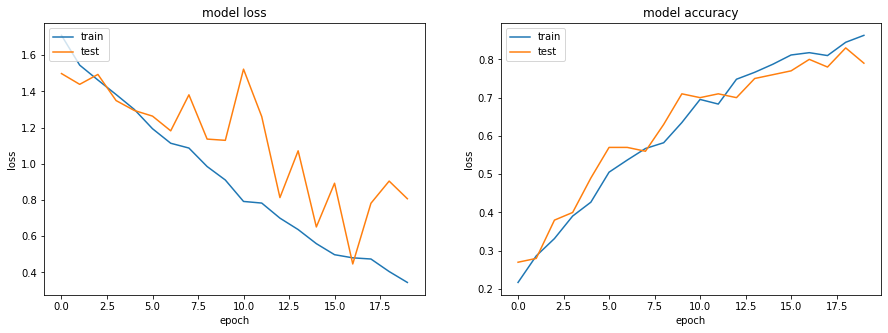

In [183]:
pla(history)

We observe that the model is learning and there is less overfitting. But on observing the plot, we realize that there is a scope for improvement in accuracies.

In [220]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
Source path =  /content/Project_data/Project_data/val ; batch size = 20
Source path =  /content/Project_data/Project_data/train ; batch size = 20
34/34 [==============================] - 52s 2s/step - loss: 1.7309 - categorical_accuracy: 0.2066 - val_loss: 1.5962 - val_categorical_accuracy: 0.2200

Epoch 00001: saving model to model_init_2020-05-2620_20_12.871761/model-00001-1.73474-0.20664-1.59620-0.22000.h5
Epoch 2/25
34/34 [==============================] - 30s 887ms/step - loss: 1.6218 - categorical_accuracy: 0.2624 - val_loss: 1.5936 - val_categorical_accuracy: 0.3000

Epoch 00002: saving model to model_init_2020-05-2620_20_12.871761/model-00002-1.62092-0.26244-1.59364-0.30000.h5
Epoch 3/25
34/34 [==============================] - 30s 890ms/step - loss: 1.4951 - categorical_accuracy: 0.3454 - val_loss: 1.4609 - val_categorical_accuracy: 0.2900

Epoch 00003: saving model to model_init_2020-05-2620_20_12.871761/model-00003-1.49106-0.34540-1.46088-0.29000.h5
Epoch 4/25
34/

In [0]:
history=model.history

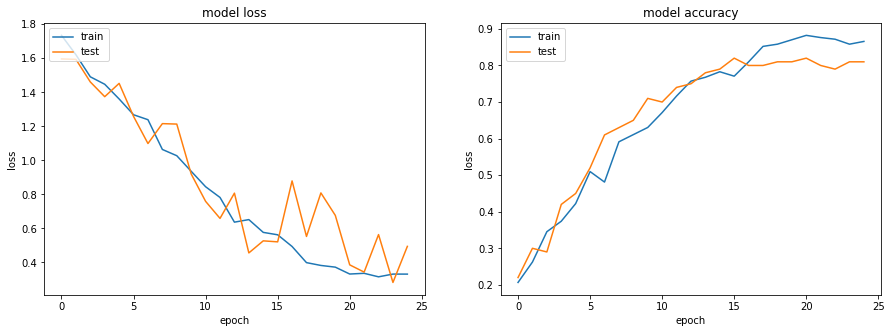

In [222]:
pla(history)

When we decrease the batch size from 32 to 20, we observe that the accuracies have improved marginally. We now try the same model with an even lower batch equal to 16 as there is still scope for improvement as observed in the graph. The Plateau has not been reached yet.

In [229]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
Source path =  /content/Project_data/Project_data/val ; batch size = 16
Source path =  /content/Project_data/Project_data/train ; batch size = 16
42/42 [==============================] - 51s 1s/step - loss: 1.7210 - categorical_accuracy: 0.2066 - val_loss: 1.6963 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2020-05-2620_35_09.202400/model-00001-1.71933-0.20664-1.69632-0.21000.h5
Epoch 2/25
42/42 [==============================] - 32s 751ms/step - loss: 1.5839 - categorical_accuracy: 0.2640 - val_loss: 1.4862 - val_categorical_accuracy: 0.3100

Epoch 00002: saving model to model_init_2020-05-2620_35_09.202400/model-00002-1.57969-0.26395-1.48625-0.31000.h5
Epoch 3/25
42/42 [==============================] - 31s 743ms/step - loss: 1.5070 - categorical_accuracy: 0.3183 - val_loss: 1.3832 - val_categorical_accuracy: 0.3600

Epoch 00003: saving model to model_init_2020-05-2620_35_09.202400/model-00003-1.50477-0.31825-1.38319-0.36000.h5
Epoch 4/25
42/

In [0]:
history=model.history

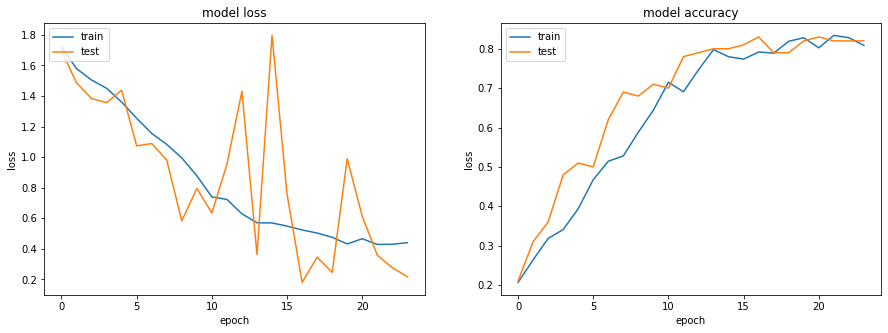

In [231]:
pla(history)

In [238]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
Source path =  Source path =  /content/Project_data/Project_data/val ; batch size = 16
/content/Project_data/Project_data/train ; batch size = 16
42/42 [==============================] - 47s 1s/step - loss: 1.5970 - categorical_accuracy: 0.3047 - val_loss: 1.3287 - val_categorical_accuracy: 0.4200

Epoch 00001: saving model to model_init_2020-05-2620_50_22.332075/model-00001-1.59719-0.30468-1.32870-0.42000.h5
Epoch 2/25
42/42 [==============================] - 31s 748ms/step - loss: 1.1996 - categorical_accuracy: 0.4992 - val_loss: 1.5815 - val_categorical_accuracy: 0.5300

Epoch 00002: saving model to model_init_2020-05-2620_50_22.332075/model-00002-1.20297-0.49925-1.58148-0.53000.h5
Epoch 3/25
42/42 [==============================] - 32s 750ms/step - loss: 1.0280 - categorical_accuracy: 0.5897 - val_loss: 1.1226 - val_categorical_accuracy: 0.5600

Epoch 00003: saving model to model_init_2020-05-2620_50_22.332075/model-00003-1.02539-0.58974-1.12260-0.56000.h5
Epoch 4/25
42/

In [0]:
history=model.history

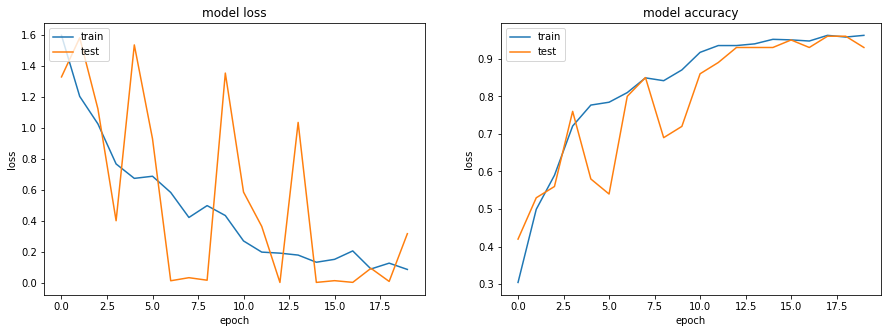

In [240]:
pla(history)

With batch size equal to 16, we observe that accuracies have certainly improved. We have now reached the training accuracy of 96% and validation accuracy of 93%. Based on the graph, we observe that the validation loss decreases in a wavy pattern and we are certain that it will again come back to near 0.

In this way, we had worked on two different kinds of architectures for video analysis.

- **Conv-3D**: The best result is with 95% Training Accuracy and 88% Validation Accuracy. It has approximately 555,000 training parameters.
- **CNN+RNN**: The best model is created using transfer learning. The base architecture used is Mobilenet. The model has approximatelt 3.5 million training parameters. This model gives us 96% Training Accuracy and 93% Validation Accuracy

We choose the ***CNN+RNN Model by Transfer Learning with Mobilenet*** as our best model as it gives the highest accuracy with minimal overfitting.

# Model Building with Edge Detection as Pre-Processing

We try to build our best models so far with a change in pre-processing. Apart from resizing and normalizing the images, we also try edge detection.

In [28]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [i for i in range(30) if i%2==1] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),90,90,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    res=cv2.resize(image,(90,90)).astype(np.uint8)
                    
                    res[:,:,0]=cv2.Canny(res[:,:,0],40,80)
                    res[:,:,1]=cv2.Canny(res[:,:,1],40,80)
                    res[:,:,2]=cv2.Canny(res[:,:,2],40,80)
                    
                    batch_data[folder,idx,:,:,0] = res[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = res[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = res[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if len(folder_list)%batch_size!=0:
            remaining=len(folder_list)%batch_size
            si=len(folder_list)-remaining
            batch_data = np.zeros((remaining,len(img_idx),90,90,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((remaining,5)) # batch_labels is the one hot representation of the output
            for folder in range(remaining):
                imgs = os.listdir(source_path+'/'+ t[si].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[si].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    res=cv2.resize(image,(90,90)).astype(np.uint8)
                    
                    res[:,:,0]=cv2.Canny(res[:,:,0],40,80)
                    res[:,:,1]=cv2.Canny(res[:,:,1],40,80)
                    res[:,:,2]=cv2.Canny(res[:,:,2],40,80)
                    
                    batch_data[folder,idx,:,:,0] = res[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = res[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = res[:,:,2]/255 #normalise and feed in the image
                        
                batch_labels[folder, int(t[si].strip().split(';')[2])] = 1
                si+=1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [38]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers


#write your model here
model=Sequential()

#first 3D conv group
model.add(Conv3D(8,(3,3,3),padding='same',input_shape=(15,90,90,3),kernel_initializer=keras.initializers.he_normal()))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(8,(3,3,3),padding='same',input_shape=(15,90,90,3),kernel_initializer=keras.initializers.he_normal()))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

#second 3D conv group
model.add(Conv3D(16,(3,3,3),padding='same',kernel_initializer=keras.initializers.he_normal()))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(16,(3,3,3),padding='same',kernel_initializer=keras.initializers.he_normal()))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

#third 3D conv group
model.add(Conv3D(32,(3,3,3),padding='same',kernel_initializer=keras.initializers.he_normal()))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(32,(3,3,3),padding='same',kernel_initializer=keras.initializers.he_normal()))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(16,activation='relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

# softmax layer
model.add(Dense(5, activation='softmax'))

In [39]:
optimiser = optimizers.SGD(lr=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_19 (Conv3D)           (None, 15, 90, 90, 8)     656       
_________________________________________________________________
activation_19 (Activation)   (None, 15, 90, 90, 8)     0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 15, 90, 90, 8)     32        
_________________________________________________________________
conv3d_20 (Conv3D)           (None, 15, 90, 90, 8)     1736      
_________________________________________________________________
activation_20 (Activation)   (None, 15, 90, 90, 8)     0         
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 7, 45, 45, 8)      0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 7, 45, 45, 8)     

In [40]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/Project_data/train'
val_path = 'Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(
    monitor='val_loss', factor=0.4, patience=3, verbose=1, mode='auto',
    min_delta=0.001, cooldown=5,min_lr=0.00001) # write the REducelronplateau code here
ES= EarlyStopping(monitor='val_loss',patience=6)
callbacks_list = [checkpoint, LR,ES]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# training sequences = 663
# validation sequences = 100
# epochs = 50


In [32]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50Source path =  Project_data/Project_data/val ; batch size =
 64
Source path =  Project_data/Project_data/train ; batch size = 64
11/11 [==============================] - 44s 4s/step - loss: 1.7844 - categorical_accuracy: 0.2941 - val_loss: 2.5249 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2020-05-2719_23_56.290015/model-00001-1.81068-0.29412-2.52492-0.23000.h5
Epoch 2/50
11/11 [==============================] - 34s 3s/step - loss: 1.3001 - categorical_accuracy: 0.4630 - val_loss: 2.4189 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model_init_2020-05-2719_23_56.290015/model-00002-1.30646-0.46305-2.41891-0.23000.h5
Epoch 3/50
11/11 [==============================] - 37s 3s/step - loss: 0.9929 - categorical_accuracy: 0.6184 - val_loss: 1.6742 - val_categorical_accuracy: 0.3800

Epoch 00003: saving model to model_init_2020-05-2719_23_56.290015/model-00003-0.99368-0.61840-1.67420-0.38000.h5
Epoch 4/50
11/11 [====================

In [33]:
history=model.history

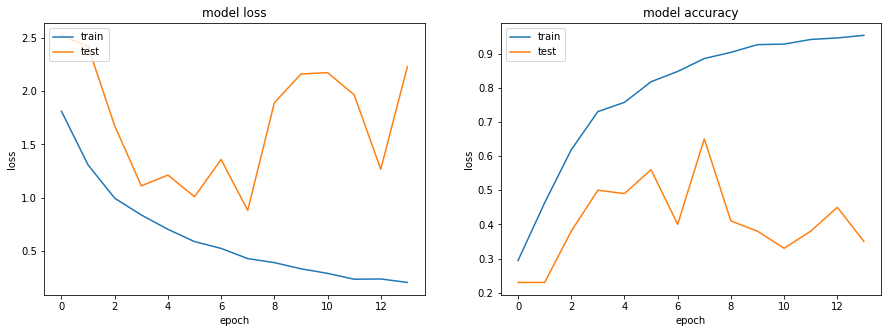

In [36]:
pla(history)

We observe that the validation loss has a potential to decrease but the curve is swinging. We add dropouts to the model.

In [42]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers


#write your model here
model=Sequential()

#first 3D conv group
model.add(Conv3D(8,(3,3,3),padding='same',input_shape=(15,90,90,3),kernel_initializer=keras.initializers.he_normal()))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(8,(3,3,3),padding='same',input_shape=(15,90,90,3),kernel_initializer=keras.initializers.he_normal()))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

#second 3D conv group
model.add(Conv3D(16,(3,3,3),padding='same',kernel_initializer=keras.initializers.he_normal()))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(16,(3,3,3),padding='same',kernel_initializer=keras.initializers.he_normal()))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

#third 3D conv group
model.add(Conv3D(32,(3,3,3),padding='same',kernel_initializer=keras.initializers.he_normal()))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Conv3D(32,(3,3,3),padding='same',kernel_initializer=keras.initializers.he_normal()))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(16,activation='relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

# softmax layer
model.add(Dense(5, activation='softmax'))

In [43]:
optimiser = optimizers.SGD(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_25 (Conv3D)           (None, 15, 90, 90, 8)     656       
_________________________________________________________________
activation_25 (Activation)   (None, 15, 90, 90, 8)     0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 15, 90, 90, 8)     32        
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 15, 90, 90, 8)     1736      
_________________________________________________________________
activation_26 (Activation)   (None, 15, 90, 90, 8)     0         
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 7, 45, 45, 8)      0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 7, 45, 45, 8)     

In [44]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/Project_data/train'
val_path = 'Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size=32

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(
    monitor='val_loss', factor=0.4, patience=3, verbose=1, mode='auto',
    min_delta=0.001, cooldown=5,min_lr=0.00001) # write the REducelronplateau code here
ES= EarlyStopping(monitor='val_loss',patience=6)
callbacks_list = [checkpoint, LR,ES]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# training sequences = 663
# validation sequences = 100
# epochs = 50


In [45]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
Source path =  Project_data/Project_data/train Source path =  Project_data/Project_data/val ; batch size = 32
; batch size = 32
21/21 [==============================] - 32s 2s/step - loss: 2.0385 - categorical_accuracy: 0.2142 - val_loss: 1.6164 - val_categorical_accuracy: 0.2000

Epoch 00001: saving model to model_init_2020-05-2719_45_44.715017/model-00001-2.03612-0.21418-1.61639-0.20000.h5
Epoch 2/50
21/21 [==============================] - 27s 1s/step - loss: 1.7519 - categorical_accuracy: 0.2941 - val_loss: 1.2299 - val_categorical_accuracy: 0.2700

Epoch 00002: saving model to model_init_2020-05-2719_45_44.715017/model-00002-1.74935-0.29412-1.22986-0.27000.h5
Epoch 3/50
21/21 [==============================] - 28s 1s/step - loss: 1.5448 - categorical_accuracy: 0.3529 - val_loss: 2.2155 - val_categorical_accuracy: 0.1600

Epoch 00003: saving model to model_init_2020-05-2719_45_44.715017/model-00003-1.54384-0.35294-2.21553-0.16000.h5
Epoch 4/50
21/21 [====================

In [46]:
history=model.history

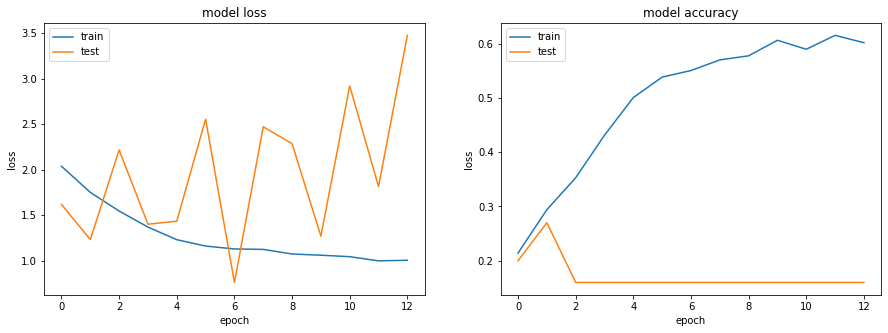

In [47]:
pla(history)

We do not see any improvement with edge detection. Hence, we use our previous models only which gave the best results.